In [ ]:
# snapshots pickles need to be inside folder "snapshots" in relation to this file's folder.
# auxiliary file "mor_fcts.py" needs to be in the same folder as this file/notebook.

In [ ]:
run_mode = "colab" # choose "colab" or "local"
colab_directory = '/content/drive/MyDrive/turbi' # Snapshot pickle files need to be inside folder "snapshots" inside this folder

# Loading data and returns the stacked snapshot matrix of all parameters:
type_data = "full"  # choose: "reduced" or "full"

# Loads each of the snapshot matrices (for each parameter) or the saved stacked version:
load_format = "stacked" # choose "each" or "stacked"


In [ ]:
# Loads auxiliary functions from file mor_fcts.py:

if run_mode == "colab":
  # mount colab drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Load functions from mor_fcts.py file
  import sys
  sys.path.append(colab_directory)
  from mor_fcts import *
else:
  from mor_fcts import *

Mounted at /content/drive


In [ ]:
# Passo 0 - Carregar Dados de Alta Fidelidade - Para Treino e Validação.
# Step 0 - Load high fidelity data - For Training and Validation.
S_train, S_val = load_high_fidelity_data_fct(
                                            mode = run_mode,
                                            data = type_data,
                                            format = load_format,
                                            colab_dir = colab_directory,
                                            )

The shape of S_train is:  (70801, 1074)
The shape of S_val is:  (70801, 179)


In [ ]:
# Passo 1 - Normalização Dados Treino.
# Step 1 - Normalization of Training Data.
min_Strain = np.min(S_train)
max_Strain = np.max(S_train)
Strain_norm = (S_train - min_Strain) / (max_Strain - min_Strain)

In [ ]:
# @title
# (---WARNING --- this is slow)
# Performs SVD via Scikit learn
# In colab, it takes about (it stops because it takes too long).... for the "full data".
# It is used to generate a plot of explained variance versus number of modes.
# This is not necessary to calculate u_pod solution (ahead)


# if type_data == "reduced":
#   dim_svd = S_train.shape[1]
# elif type_data = "full":
#   dim_svd = S_train.shape[1]
# else:
#   print("Choose the appropriate value for 'type_data'.")

dim_svd = Strain_norm.shape[1]

svd_S = svd_sklearn(Strain_norm, dim_svd) # svd_sklearn is a fct in the aux. file.
explain_var(svd_S, print_EV=True, plot=True) # explain_var is a fct in the aux. file.

In [ ]:
# Verificando Normalização Passo 1 foi feita corretamente.
# Checking Normalization of Step 1 was successful.
print(Strain_norm.min())
print(Strain_norm.max())

0.0
1.0


In [ ]:
# Passo 2 - Realizar Decomposição em Valores Singulares
# Step 2 - Perform Singular Value Decomposition (SVD)

# Cálculo do Posto dos dados de Treino. Necessário mais a frente para definir o número de modos para o valor de erro desejado.
# Calculate rank of Training Data. This is necessary ahead when defining the number of modes for a certain level of prescribed error.
rank_Strain_norm = np.linalg.matrix_rank(Strain_norm, tol=None, hermitian=False)
print("The rank of the snapshot matrix (training data) is: ", rank_Strain_norm)

# Cálculo da Decomposição em si:
# Performing SVD:
u, s, vt = svd(Strain_norm)

The rank of the snapshot matrix (training data) is:  1065


In [ ]:
# Passo 3 - Construção de V e uN
# Step 3 - Construction of V and uN

# Goal epsilon (as  last equation of page 4 of paper)
# for eps = 1e-4, N=128=2**7

# for eps = 1.0e-2, N=17
# for eps = 1.0e-3, N=59
# for eps = 9.5e-4, N=64
# for eps = 1e-4, N=128=2**7

eps = 1.0e-6

# Finding N given epsilon and perform SVD and calculate POD solution or
#  conclude no N exists for the prescribed error:
N = find_N(s, eps)
if N != None:
  print("The number of modes to reach the given error is: ", N)

  if N < rank_Strain_norm:
    # Assembling SVD approximation (to be used as input to autoencoder)
    #  and POD solution.
    # Assembling uN:
    V = u[:,0:N]
    Vt = np.transpose(V)
    uN = np.matmul(Vt,Strain_norm)
    print("The shape of the SVD solution is ", uN.shape)
    print("The shape of the full order solution is: ", Strain_norm.shape)
    u_pod = np.matmul(V,uN)
    print("The shape of the upod solution is: ", u_pod.shape)
    dif_uh_upod = Strain_norm - u_pod
    print("The shape of the diference between high fidelity solution and POD solution is: ", dif_uh_upod.shape)

    print("The maximum absolute error in any point of training is: ", np.array2string(np.max(np.abs(dif_uh_upod)), formatter={'float_kind':'{0:.8f}'.format})  )
    print("The average absolute error in any point of training is: ", np.array2string(np.mean(np.abs(dif_uh_upod)), formatter={'float_kind':'{0:.8f}'.format}) )
    #print("The average absolute error in any point of training is: ", np.mean(np.abs(dif_uh_upod)).round(5) )

  else:# N is larger than rank of S_train:
    print("The choosen N (SVD latent space) for such epsilon is larger or equal to the rank of S_train.")
    print(" You need to redefine epsilon (larger) so that an smaller N is possibly smaller than rank of S_train.")

else:
  print('There is no N that can achieve such epsilon!')


The number of modes to reach the given error is:  270
The shape of the SVD solution is  (270, 1074)
The shape of the full order solution is:  (70801, 1074)
The shape of the upod solution is:  (70801, 1074)
The shape of the diference between high fidelity solution and POD solution is:  (70801, 1074)
The maximum absolute error in any point of training is:  0.01248173
The average absolute error in any point of training is:  0.00005006


In [ ]:
print("Error POD:")
norm_S_train_L1 = np.linalg.norm(Strain_norm, ord=1)
error_POD_L1 = ( np.linalg.norm(dif_uh_upod, ord=1) ) / norm_S_train_L1
print("Matrix error L1 is: ", error_POD_L1.round(5))

norm_S_train_L2 = np.linalg.norm(Strain_norm, ord=2)
error_POD_L2 = ( np.linalg.norm(dif_uh_upod, ord=2) ) / norm_S_train_L2
print("Matrix error L2 is: ", error_POD_L2.round(5))

norm_S_train_Linf = np.linalg.norm(Strain_norm, np.inf)
error_POD_Linf = ( np.linalg.norm(dif_uh_upod, np.inf ) ) / norm_S_train_Linf
print("Matrix error L_infinity is: ", error_POD_Linf.round(5))

Error POD:
Matrix error L1 is:  0.00093
Matrix error L2 is:  0.00023
Matrix error L_infinity is:  0.00212


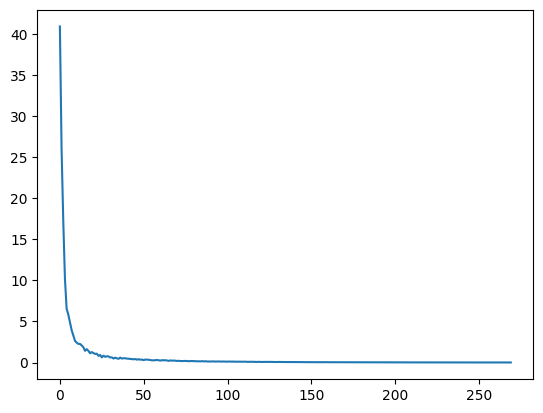

In [ ]:
# Decay of modes
list_avg_abs_mode = []
for i in range(uN.shape[0]):
  list_avg_abs_mode.append(np.mean(np.abs(uN[i])))

plt.plot(list_avg_abs_mode)
plt.show()

In [ ]:
# Passo 4 - Regressão:
# Step 4 - Regression:

In [ ]:
# Passo 4.1.1 - Construção X_train da Regressão
# Step 4.1.1 - Construction of X_train for Regression

#import numpy as np
len_temporal = S_val.shape[1]
Nmu = [0, 2, 4, 6, 8, 10]
Nt = [x+1 for x in range(len_temporal)]

X_train = np.array([(a, b) for a in Nmu for b in Nt])
# still to normalize - done ahead!

In [ ]:
# Passo 4.1.2 - Construção y_train da Regressão
# Step 4.1.2 - Construction of y_train for Regression

# Preparing y_train:
uNT = np.transpose(uN) # Transpose due to pytorch
y_train = uNT
# still to normalize - done ahead!

In [ ]:
# Passo 4.2.1 - Normalização X_train
# Step 4.2.1 - Normalization X_train

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(X_train)

# Confirming normalization of X_train:
print(X_train_minmax.min())
print(X_train_minmax.max())

In [ ]:
# Confirming order of error of successive application of scaler and its inverse:
X2 = min_max_scaler.inverse_transform(X_train_minmax)
print(np.max(X2 - X_train))

In [ ]:
# Passo 4.2.2 - Normalização y_train
# Step 4.2.2 - Normalization y_train

y_train_min = y_train.min()
y_train_max = y_train.max()
y_train_norm = (y_train - y_train_min) / (y_train_max - y_train_min)

# Confirming normalization of y_train:
print(y_train_norm.min())
print(y_train_norm.max())

print(y_train_norm.shape)

In [ ]:
# Passo 4.3 - Definição Classe Dados para Rede Neural (Requisito PyTorch)
# Step 4.3 - Definition Data Class for the Neural Network (PyTorch´s requirement)

class MorTurbiDatasetSVD(torch.utils.data.Dataset):
  # features in cols [0,11], poverty in [12], price in [13]

  def __init__(self, X, y): # X, y are of numpy type.
    #all_xy = np.loadtxt(src_file, usecols=range(0,14), delimiter="\t", comments="#", dtype=np.float32)
    X_ = X
    y_ = y

    # !!! specify torch 32 ???????????????????????????????????????
    self.x_data = torch.tensor(X_, dtype= torch.float32)#.to(device)
    self.y_data = torch.tensor(y_, dtype= torch.float32)#.to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    preds = self.x_data[idx]
    latent_conc = self.y_data[idx]
    return (preds, latent_conc)  # as a tuple

In [ ]:
# Passo 4.4 - Instanciação da Classe de dados para a Rede Neural e definição tamanho batch.
# Step 4.4 - Instantiation of Data Class for the neural Network and batch size definition.
b_size_reg_svd = 6
train_ds = MorTurbiDatasetSVD(X = X_train_minmax, y= y_train_norm)
train_ldr = torch.utils.data.DataLoader(dataset = train_ds, batch_size= b_size_reg_svd, shuffle=False)

In [ ]:
# Passo 4.5 - Definição Classe que constrói a Rede Neural para a Regressão.
# Step 4.5 - Definition of the Class constucting the Neural Network for the Regression.

l1 = 2 # number of columns of X0 (parameter and time_point)  # pick from X_train
l2 =  y_train.shape[1] # dimension of the vector trying to be predicted = size of latent space. # pick from y_train

# Autoencoder class
class NN_regressionSVD(torch.nn.Module):
  def __init__(self):
      super().__init__()

      self.reg = torch.nn.Sequential(
                            torch.nn.Linear(l1, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            torch.nn.Linear(50, l2),
                            torch.nn.Sigmoid(),
                            )


  def forward(self, x):
      estimated = self.reg(x)
      return estimated

In [ ]:
# Passo 4.6 - Instanciação Classe Rede Neural e definição parâmetros do processo de Treino.
# Step 4.6 - Instantiation of the class for the Neural network and definition of parameters related to the training process.

lr_reg = 5.0e-3 # learning rate (fixed one if no LR scheduler, initial one in case of use of scheduler)

loss_func_reg =  torch.nn.MSELoss() #torch.nn.L1Loss()  # mean avg error torch.nn.MSELoss()
#loss_function = torch.nn.SmoothL1Loss(beta = 2.0)#torch.nn.HuberLoss(delta=1e-1)#torch.nn.SmoothL1Loss(beta = 0.1)#torch.nn.HuberLoss(delta=1e-3)#torch.nn.SmoothL1Loss()# torch.nn.HuberLoss()#torch.nn.HuberLoss(reduction='mean', delta=1.0) #torch.nn.MSELoss()
# torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

# Number of epochs:
n_epochs_reg = 2000 #20000

# Definition of weights initialization:
def init_weights_reg(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
      #torch.nn.init.xavier_uniform(m.weight)
      #m.bias.data.fill_(0.01)

# Starting the model
model_reg = NN_regressionSVD() # instantiation of Regression Model

model_reg.apply(init_weights_reg) # initialize weights with He normal initialiser.

# Definition of Optimizer:
optimizer_reg = torch.optim.Adam(
    model_reg.parameters(),
    lr=lr_reg,
    #betas=(0.9, 0.999),
    #eps = 1e-08,
    #weight_decay = 1e-8,
    )


# Choice of schedulers for adaptive Learning Rate:
#scheduler_reg = torch.optim.lr_scheduler.ExponentialLR(optimizer_reg, gamma=0.85)
scheduler_reg = torch.optim.lr_scheduler.StepLR(optimizer_reg, step_size=50, gamma=0.75)
#scheduler_reg = torch.optim.lr_scheduler.MultiStepLR(optimizer_reg, milestones=[20,50,100,150,200,300,500,1000], gamma=0.55)

In [ ]:
# Passo 4.7 - Treino da Rede Neural - Regressão.
# Step 4.7 - Training Process for the Neural Network - Regression.

from tqdm.notebook import trange
start = time.time()
print("Starting time counting \n")

epochs = n_epochs_reg

outputs_reg = []
reg_avg_loss_by_epoch = []

# Running loop of epochs:
for epoch in trange(epochs):
#for epoch in range(epochs):
    time_epoch = time.time()
    losses_batches_per_epoch = []

    for k, image in enumerate(train_ldr):

          c = k % 50
          reconstructed = model_reg(image[0])
          loss_reg = loss_func_reg(reconstructed, image[1])

          optimizer_reg.zero_grad()
          loss_reg.backward()
          optimizer_reg.step()

          losses_batches_per_epoch.append(loss_reg)

    # Learning rate scheduler:
    before_lr = optimizer_reg.param_groups[0]["lr"]

    #m_epoch = epoch % 50
    #if m_epoch == 0:
    #  scheduler_reg.step()

    scheduler_reg.step()
    after_lr = optimizer_reg.param_groups[0]["lr"]

    temp_loss_batch = losses_batches_per_epoch

    item_fct9 = lambda x: x.item()
    l_loss = np.array(list(map(item_fct9, temp_loss_batch)))
    temp_avg_loss_epoch = l_loss.mean()
    print('Average loss at epoch ', epoch, ' was ', round(temp_avg_loss_epoch, 7), "and it took ", round(time.time() - time_epoch,3), " seconds. ", "LR %.7f -> %.7f" % (before_lr, after_lr), " .") #, "\n")  " LR: ", before_lr, " to ", after_lr
    # "Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr)
    reg_avg_loss_by_epoch.append(temp_avg_loss_epoch)

    outputs_reg.append((epochs, image, reconstructed))


# Time counting:
end = time.time()
total_time = end - start
print("\nLoop with ", epochs, "epochs took ", round(total_time,2) , " seconds.")
print("An average of ", round(total_time/epochs,4), " seconds per epoch.")

In [ ]:
# Plot depicting decay of loss along epochs:
plt.plot(reg_avg_loss_by_epoch[0:])
plt.show()

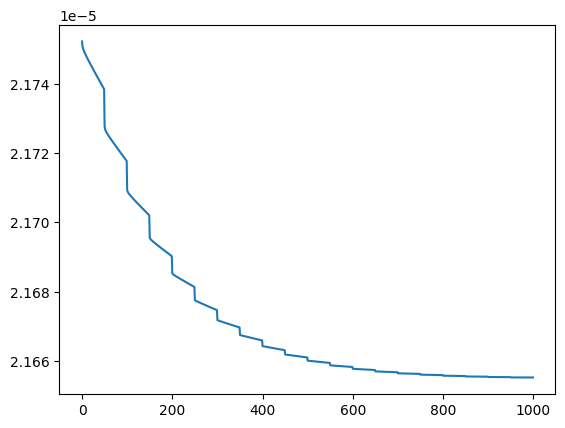

In [ ]:
plt.plot(reg_avg_loss_by_epoch[1000:])
plt.show()

In [ ]:
# Predição a partir do modelo de Regressão treinado.
# Prediction from trained regression model.


In [ ]:
# Passo 5.0 - A fazer - Carregar Modelo
# Step 5.0 - TBD - Load Model


In [ ]:
# Passo 5.1 - Construção X_val
# Step 5.1 - Construction X_val

# Fabricating X_val for evaluating regression predition:
Nval = [5]
X_val = np.array([(a,b) for a in Nval for b in Nt])
# still to normalize

In [ ]:
# Passo 5.2 - Normalização de X_val segundo 4.2.1
# Step 5.2 - Normalization of X_val according to 4.2.1

X_val_minmax = min_max_scaler.transform(X_val)

print(X_val_minmax.min())
print(X_val_minmax.max())

In [ ]:
# Passo 5.3 - Cálculo predição do modelo sobre X_val_minmax.
# Step 5.3 - Evaluation of the model over X_val_minmax.

# Transforming X_val_minmax in Tensor format to be used by pytorch model
X_val_minmax_tensor = torch.tensor(X_val_minmax, dtype= torch.float32)

y_val_norm_pred_tensor = model_reg(X_val_minmax_tensor) # output is a tensor
print(y_val_norm_pred_tensor.shape)

# converts tensor to numpy:
fct1 = lambda x: x.detach().numpy()
# Adjusting format/type of rec_data to numpy format with same dimensions as original_data:
y_val_norm_pred_np = np.stack(list(map(fct1, y_val_norm_pred_tensor)), axis=1)
print(type(y_val_norm_pred_np))
print(y_val_norm_pred_np.shape)

print(y_val_norm_pred_np.min())
print(y_val_norm_pred_np.max())

In [ ]:
# Passo 5.4 - Inversão da normalização feita em 4.2.2.
# Step 5.4 - Inversion of Normalization performed in 4.2.2

y_val_pred_np = y_val_norm_pred_np * (y_train_max - y_train_min) + y_train_min
print(y_val_pred_np.min())
print(y_val_pred_np.max())

In [ ]:
# Passo 6 - Retorno à dimensão original pré-svd (dimensão espaço físico)
# Step 6 - Returning to the original dimension pre-svd (physical space dimension)

y_val_pred_phys_norm = np.matmul(V,y_val_pred_np)
print(y_val_pred_phys_norm.shape)
print(y_val_pred_phys_norm.min())
print(y_val_pred_phys_norm.max())

In [ ]:
# Passo 7 - Inversão normalização feita no Passo 1.
# Step 7 - Inversion normalization performed on Step 1.

y_val_pred_phys = y_val_pred_phys_norm * (max_Strain - min_Strain) + min_Strain
print(y_val_pred_phys.shape)
print(y_val_pred_phys.min())
print(y_val_pred_phys.max())

In [ ]:
# Passo 8 - Cálculo erros l2 e linf entre predição regressão SVD e valor real
# Step 8 - Evaluation of l2 and linf errors between prediction based on SVD regression and real value.

# check both vectors have same dimensions # Numpy may calculate difference even if dimension do no match
print(y_val_pred_phys.shape)
print(S_val.shape)



In [ ]:
import pickle

# Save the predicted numpy array with Pickle
with open("/content/drive/MyDrive/turbi/" + "svd_" + str(N) + ".pkl", 'wb') as f:
    pickle.dump(y_val_pred_phys, f)

# Save the original numpy array with Pickle
#with open("/content/drive/MyDrive/turbi/" + "S_val.pkl", 'wb') as f:
#    pickle.dump(S_val, f)

In [ ]:
import pickle
import joblib

In [ ]:
S_val = joblib.load("/content/drive/MyDrive/turbi/" + "snapshots/" + "snapshots_theta_5_5_to_895" + ".pkl")

In [ ]:
# open a file, where you stored the pickled data
file = open("/content/drive/MyDrive/turbi/" + "svd_" + str(270) + ".pkl", 'rb')

# dump information to that file
y_val_pred_phys = pickle.load(file)

In [ ]:
y_val_pred_phys.shape

(70801, 179)

In [ ]:
S_val.shape

(70801, 179)

In [ ]:
diff_pred_true = y_val_pred_phys - S_val
print(diff_pred_true.shape)
print(diff_pred_true.min())
print(diff_pred_true.max())

(70801, 179)
-0.4732607742024922
0.4927614896247258


In [ ]:
# l2 and linfinity norms of error:
from numpy import linalg as LA
nm_2 = LA.norm(diff_pred_true, ord = 2, axis=0, keepdims = True)
nm_inf = LA.norm(diff_pred_true, ord = np.inf, axis=0, keepdims = True)
print(nm_2.shape)
print(nm_inf.shape)
print(nm_2.min())
print(nm_2.max())
print(nm_inf.min())
print(nm_inf.max())

(1, 179)
(1, 179)
1.7110887221379338
9.80984187795185
0.09098698066357158
0.4927614896247258


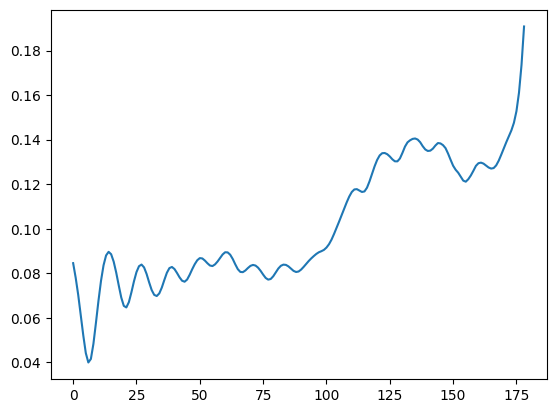

In [ ]:
# @title
# Plot of absolute relative error:
plt.plot(np.transpose(nm_2)/np.transpose(LA.norm(S_val, ord = 2, axis=0, keepdims = True)))
plt.show()

In [ ]:
diff_pred_true.shape[0]

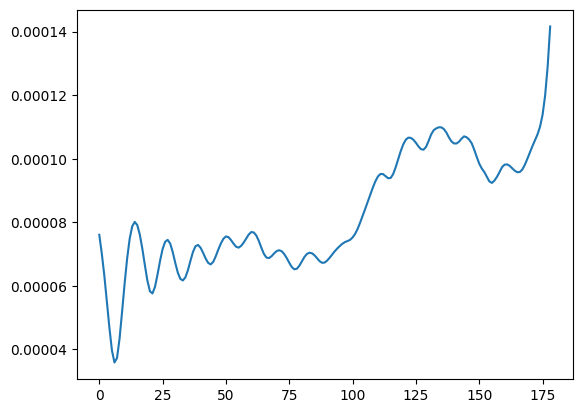

In [ ]:
# @title
# Plot l2 error scaled by number of points:
plt.plot(np.transpose(nm_2)/diff_pred_true.shape[0])
plt.show()

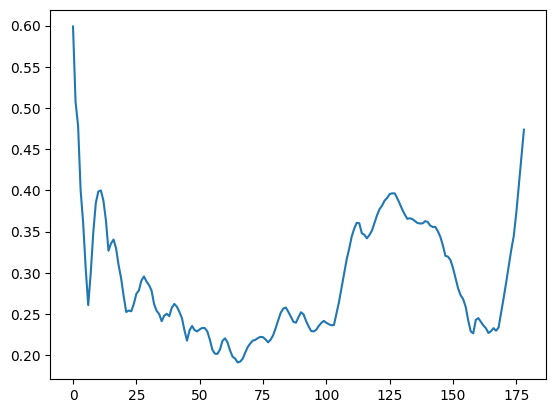

In [ ]:
# @title
# Plot linfinity error:
plt.plot(np.transpose(nm_inf))
plt.show()

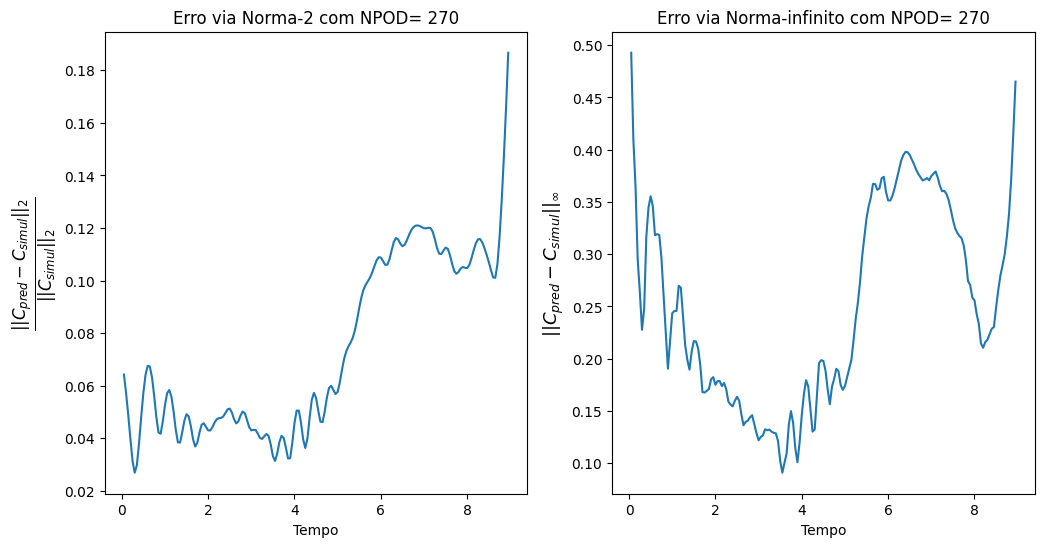

In [ ]:
# Plot of absolute relative error:

# data
e_r_p_2 = (np.transpose(nm_2)/np.transpose(LA.norm(S_val, ord = 2, axis=0, keepdims = True)) )

# axis definition:
x_erp = np.arange(0.05, 9.0, 0.05)

# Plot curves:
#fig, (ax1,ax2) = plt.subplots(1,2)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First plot - Norma 2 - Erro relativo absoluto percentual
ax1.plot(x_erp,e_r_p_2)

# r'$\latex$'
N = 270
#formatting axes
tit_graph = "Erro via Norma-2 com NPOD= " + str(N)
ax1.set_title(tit_graph)
ax1.set_xlabel("Tempo")
ax1.set_ylabel(r'$\frac{||C_{pred} - C_{simul}||_2}{||C_{simul}||_2}$', fontsize=17)
#ax1.set_ylabel(r'$||C_pred - C_simul||_2 / ||C_simul||_2$')
#ax1.set_xlim(0,15)
#ax1.set_ylim(-0.9, 0.9)
#ax1.legend(["",""])

# Second plot - Norma Infinito - Erro
ax2.plot(x_erp,np.transpose(nm_inf))
ax2.set_title("Erro via Norma-infinito com NPOD= " + str(N))
ax2.set_xlabel("Tempo")
#ax2.set_ylabel("Concentração")
ax2.set_ylabel(r'$||C_{pred} - C_{simul}||_\infty$', fontsize=13)

# Displaying the figure
plt.show()


In [ ]:
x_erp

(1, 179)

In [ ]:
import pandas as pd

e2_series = pd.Series(e_r_p_2.flatten(), name='svd_270_l2')
einf_series = pd.Series(nm_inf.flatten(), name='svd_270_linf')
time_series = pd.Series(x_erp, name='times')

# Create a DataFrame
df = pd.concat([time_series, e2_series, einf_series],axis=1)


In [ ]:
df

,times,svd_270_l2,svd_270_linf
0,0.05,0.064281,0.492761
1,0.10,0.057129,0.409630
2,0.15,0.048873,0.364539
3,0.20,0.039713,0.295226
4,0.25,0.031278,0.263574
...,...,...,...
174,8.75,0.116755,0.317058
175,8.80,0.130828,0.338658
176,8.85,0.147397,0.372055
177,8.90,0.166013,0.416393


In [ ]:
# Write the DataFrame to a CSV file
df.to_csv("/content/drive/MyDrive/turbi/" + "svd_270_errors.csv", index=False)  # index=False argument is used to prevent pandas from writing row indices into the CSV file

In [ ]:
# Function to construct histogram:
def hist(data, bins, title, labels, range = None):
  fig = plt.figure(figsize=(15, 8))
  ax = plt.axes()
  plt.ylabel("Proportion")
  #values, base, _ = plt.hist( data  , bins = bins, normed=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
  values, base, _ = plt.hist( data  , bins = bins, alpha = 0.5, color = "green", range = range, label = "Histogram")
  ax_bis = ax.twinx()
  values = np.append(values,0)
  ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
  plt.xlabel(labels)
  plt.ylabel("Proportion")
  plt.title(title)
  ax_bis.legend();
  ax.legend();

  #plt.grid()
  plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

  plt.show()
  return

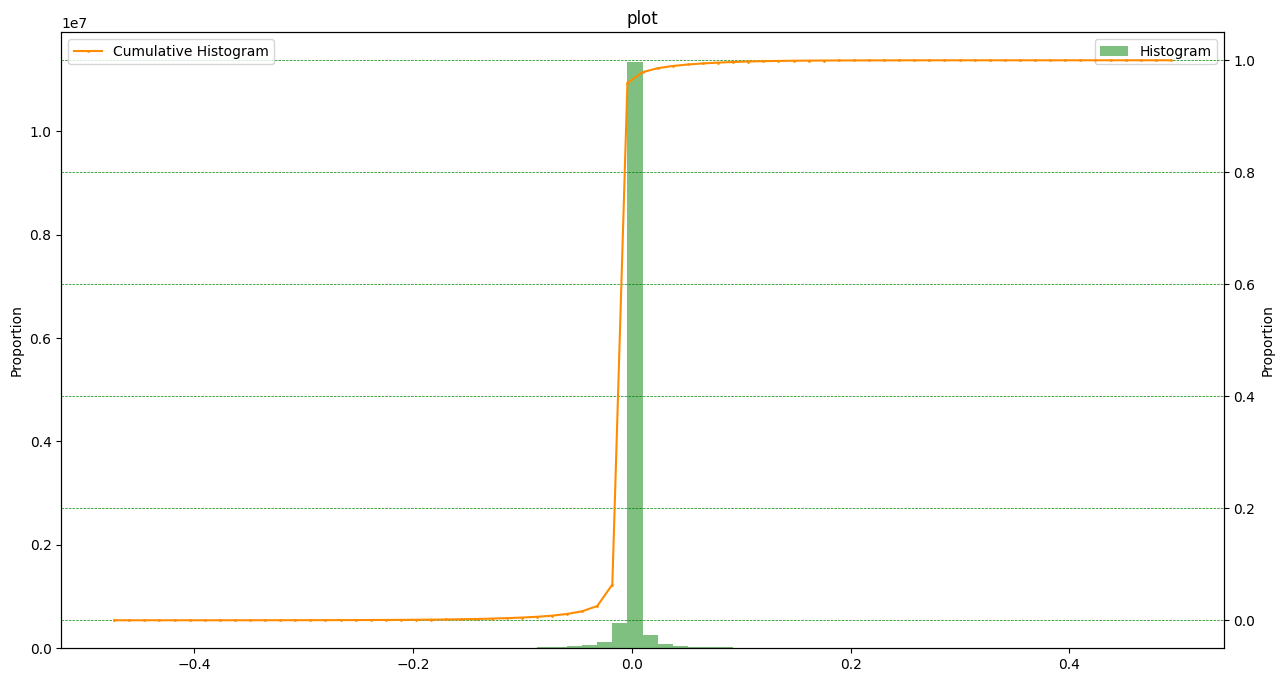

In [ ]:
# Generation of histogram:
hist(data = diff_pred_true.flatten(), bins = 70, title = 'plot', labels = 'titulo_label')